In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from transformers import RobertaPreTrainedModel, RobertaModel
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Source: https://github.com/LCS2-IIITD/Emotion-Flip-Reasoning/blob/main/Dataloaders/nlp_utils.py
import string
import nltk
import re

numbers = {
    "0":"zero",
    "1":"one",
    "2":"two",
    "3":"three",
    "4":"four",
    "5":"five",
    "6":"six",
    "7":"seven",
    "8":"eight",
    "9":"nine"
}

def remove_puntuations(txt):
    punct = set(string.punctuation)
    txt = " ".join(txt.split("."))
    txt = " ".join(txt.split("!"))
    txt = " ".join(txt.split("?"))
    txt = " ".join(txt.split(":"))
    txt = " ".join(txt.split(";"))
    
    txt = "".join(ch for ch in txt if ch not in punct)
    return txt

def number_to_words(txt):
    for k in numbers.keys():
        txt = txt.replace(k,numbers[k]+" ")
    return txt

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'_',' ',text)
    text = number_to_words(text)
    text = remove_puntuations(text)
    text = ''.join([i if ord(i) < 128 else '' for i in text])
    text = ' '.join(text.split())
    return text

In [3]:
val_data_utt = json.load(open('../../../Dataset/ERC_utterance_level/val_utterance_level.json'))
test_data_utt = json.load(open('../../../Dataset/ERC_utterance_level/test_utterance_level.json'))

val_data_conv_pred = json.load(open('../../../Dataset/ERC_conversational_level/val_conversation_level.json'))
test_data_conv_pred = json.load(open('../../../Dataset/ERC_conversational_level/test_conversation_level.json'))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
emotion2int = {
    'anger': 0,
    'joy': 1,
    'fear': 2,
    'disgust': 3,
    'neutral': 4,
    'surprise': 5,
    'sadness': 6
}
int2emotion = {v: k for k, v in emotion2int.items()}

In [6]:
utterance2vec = pickle.load(open('../../../Dataset/Embeddings/sentence_transformer_utterance2vec_768.pkl', 'rb'))

In [7]:
MAX_CONV_LEN = 35
# Defined index 7 for padding
class ERC_Dataset_Utt_Level_Inference(Dataset):
    def __init__(self, data, utterance2vec, testing=False):
        self.data = data
        self.utterance2vec = utterance2vec
        self.testing = testing

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[f'id_{idx+1}']['text']
        if not self.testing:
            emotion = self.data[f'id_{idx+1}']['emotion']
        context = self.data[f'id_{idx+1}']['context']

        context_embeddings = [torch.tensor(self.utterance2vec[preprocess_text(utterance)]) for utterance in context]
        target_embedding = torch.tensor(self.utterance2vec[preprocess_text(text)])
        context_embeddings.append(target_embedding)
                
        if(len(context_embeddings)<MAX_CONV_LEN):
            num_pads = MAX_CONV_LEN - len(context_embeddings)
            attention_mask = [1]*len(context_embeddings) + [0]*num_pads
            context_embeddings = context_embeddings + [torch.zeros(768)]*num_pads
        else:
            context_embeddings = context_embeddings[len(context_embeddings)-MAX_CONV_LEN:]
            attention_mask = [1]*MAX_CONV_LEN

        context_embeddings = torch.stack(context_embeddings)
        attention_mask = torch.tensor(attention_mask)

        if not self.testing:
            return {
                'context_embeddings': context_embeddings,
                'target_embedding': target_embedding,
                'attention_mask': attention_mask,   
                'emotion': emotion2int[emotion]
            }
        
        return {
            'context_embeddings': context_embeddings,
            'target_embedding': target_embedding,
            'attention_mask': attention_mask
        }

In [8]:
class RobertaForSentenceClassificationGivenContext(RobertaPreTrainedModel):
    def __init__(self, config,weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.weights = weights
        self.roberta = RobertaModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size*2, config.num_labels)
        self.post_init()

    def forward(self, context_embeds, target_embeds, attention_mask, labels=None,device="cpu"):
        output = self.roberta(inputs_embeds=context_embeds, attention_mask=attention_mask)
        out_target = [output.last_hidden_state[b][int(sum(attention_mask[b]))-1] for b in range(output.last_hidden_state.shape[0])]
        out_target = torch.stack(out_target)
        out_target = self.dropout(out_target)
        out_target_cat = torch.cat((out_target, target_embeds), 1)
        logits = self.classifier(out_target_cat)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.weights.to(device))
            loss = loss_fct(logits.view(-1, self.num_labels).to(device), labels.view(-1).to(device))

        return {'loss': loss, 'logits': logits}
        

In [9]:
val_dataset = ERC_Dataset_Utt_Level_Inference(val_data_utt, utterance2vec)
test_dataset = ERC_Dataset_Utt_Level_Inference(test_data_utt, utterance2vec, testing=True)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
model = torch.load('RoBERTa_Utt_Level.pth', map_location=device)

### Inference on Validation

In [11]:
model.eval()
val_pred, val_true = [], []
with torch.no_grad():
    for batch in tqdm(val_loader):
        context_embeddings, target_embedding, emotions, attention_mask = batch['context_embeddings'].to(device), batch['target_embedding'].to(device), batch['emotion'].to(device), batch['attention_mask'].to(device)
        outputs = model(context_embeds=context_embeddings, target_embeds=target_embedding, attention_mask=attention_mask, labels=emotions)
        val_pred.extend(torch.argmax(outputs['logits'], 1).tolist())
        val_true.extend(emotions.tolist())
            
val_report = classification_report(val_true, val_pred, target_names=emotion2int.keys(), zero_division=0)
val_report_dict = classification_report(val_true, val_pred, target_names=emotion2int.keys(), output_dict=True, zero_division=0)
print(f"Val Report: \n{val_report}")

100%|██████████| 1475/1475 [02:44<00:00,  8.95it/s]

Val Report: 
              precision    recall  f1-score   support

       anger       0.24      0.32      0.27       192
         joy       0.33      0.65      0.44       254
        fear       0.10      0.22      0.13        37
     disgust       0.09      0.31      0.14        42
     neutral       0.63      0.17      0.27       630
    surprise       0.32      0.38      0.34       184
     sadness       0.35      0.29      0.32       136

    accuracy                           0.31      1475
   macro avg       0.29      0.33      0.27      1475
weighted avg       0.43      0.31      0.30      1475



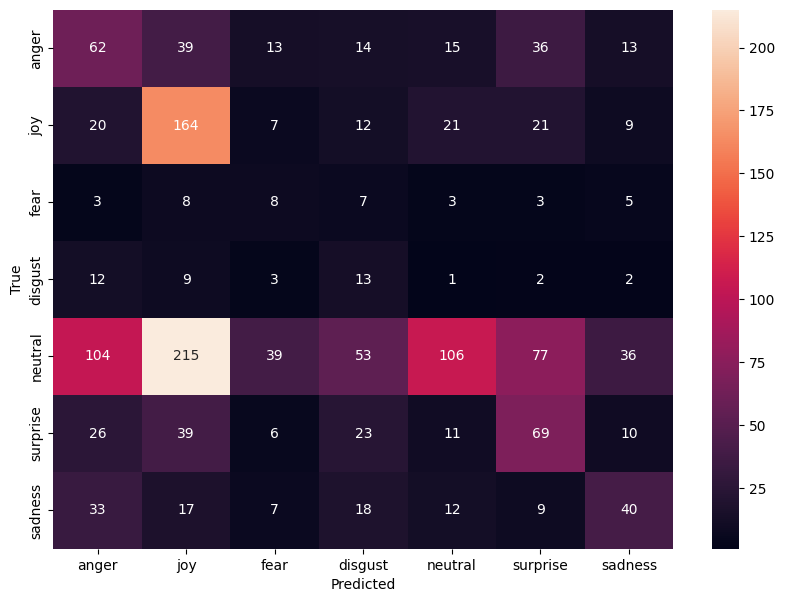

In [12]:
# Confusion Matrix
cm = confusion_matrix(val_true, val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion2int.keys(), yticklabels=emotion2int.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
count = 0
for i in range(len(val_data_conv_pred)):
    for j in range(len(val_data_conv_pred[i]['conversation'])):
        val_data_conv_pred[i]['conversation'][j]['emotion'] = int2emotion[val_pred[count]]
        count += 1

In [14]:
json.dump(val_data_conv_pred, open('val_conversation_level_pred.json', 'w'), indent=4)

### Inference on Testing

In [15]:
model.eval()
test_pred = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        context_embeddings, target_embedding, attention_mask = batch['context_embeddings'].to(device), batch['target_embedding'].to(device), batch['attention_mask'].to(device)
        outputs = model(context_embeds=context_embeddings, target_embeds=target_embedding, attention_mask=attention_mask)
        test_pred.extend(torch.argmax(outputs['logits'], 1).tolist())

100%|██████████| 6301/6301 [11:20<00:00,  9.26it/s]


In [16]:
count = 0
for i in range(len(test_data_conv_pred)):
    for j in range(len(test_data_conv_pred[i]['conversation'])):
        test_data_conv_pred[i]['conversation'][j]['emotion'] = int2emotion[test_pred[count]]
        count += 1

In [17]:
json.dump(test_data_conv_pred, open('test_conversation_level_pred.json', 'w'), indent=4)